# DRMM (Deep Relevance Matching Model)

_Ismaël Bonneau_

Mots-clés: _Relevance Matching_, _Semantic Matching_, _Neural Models_,
_Ad-hoc Retrieval_, _Ranking Models_


#### But de ce notebook: Comprendre et construire une architecture **DRMM** fonctionnelle avec **pytorch**, et l'expliquer de façon concise.

Un gros bisou à Daniel Godoy pour son tutoriel <a href="https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e">comprendre pytorch par l'exemple pas à pas</a> (en Anglais).

Pour cela, 2 étapes:

- construire la chaîne de pré traitements:
    - générer des paires document-requête non pertinentes et pertinentes pour l'apprentissage
    - générer des histogrammes d'interaction locales au niveau document-requête
- construire l'architecture DRMM

Les interractions sont pour le moment des interactions locales sur des word embeddings et sont mesurées comme une similarité cosinus entre les vecteurs des mots de la requête et ceux du document.

## En quoi consiste le modèle DRMM?

lien vers <a href="https://arxiv.org/pdf/1711.08611.pdf">l'article</a> (en Anglais) par _Jiafeng Guo_, _Yixing Fan_, _Qingyao Ai_, _W. Bruce Croft_ (2017) [1]

DRMM (Deep Relevance Matching Model) est un modèle de réseau de neurones profond pour la RI (recherche d'information).

Un des objectifs principaux de la RI est de déterminer la **pertinence** d'un document (cela peut être un document court sous forme d'un paragraphe, ou long, voire très long) par rapport à une requête donnée. Un moteur de RI traditionnel retournera alors une liste ordonnée des documents par pertinence par rapport à une requête posée par l'utilisateur, avec en tête de liste les documents les plus pertinents.

Un problème qui se pose avec de nombreux modèles de RI est . Certains termes de la requête ne se trouvent pas toujours dans des documents qui sont pourtant pertinents pour cette requête. Pensons à une requête sur la pigeons dans la ville de Paris: Un document qui aurait pour sujet le "problème envahissant des oiseaux dans la capitale Française", sans contenir une seule fois les mots Pigeons et Paris, aurait peu de chance d'être considéré comme pertinent.

Plusieurs solutions sont donc proposées pour résoudre ce problème.

DRMM est un modèle **orienté interactions**, qui applique une fonction apprise (un réseau de neurones n'est rien d'autres qu'une fonction très complexe) à des interactions entre un document et une requête, qui ne font donc pas partie du réseau et ne sont pas apprises. Cette fonction a pour but de calculer un **score pour la paire document-requête**, score d'autant **plus élevé que le document est pertinent pour la requête**.

Il se compose de deux parties: 

- Une partie **"feed forward matching network"** qui est un simple perceptron multicouche. Il s'agit dans l'implémentation de [1] d'un perceptron à 3 couches, de taille 30 neurones, 5 neurones, et 1 neurone. Cette partie vient calculer un score pour l'interaction de chaque terme de la requête avec l'ensemble des termes du document. Pour une requête de 5 termes, le partie feed forward matching produira donc un vecteur de dimension 5, pour 1 score par terme de la requête. On a donc un bloc qui prend en entrée une matrice d'interactions des termes de la requête, et qui rend en sortie un vecteur de score pour chaque terme de la requête.

- Une partie **"term gating network"** qui est un perceptron à une couche. Il s'agit uniquement d'apprendre un vecteur qui vient mutiplier chaque "vecteur de terme" de la requête et ensuitepondérer les scores calculés par la partie feed forward. 

<img src="images/DRMMschema.png" width="700"> 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os import sep
import os
import random
import pickle

import torch

%matplotlib inline
%load_ext autoreload
%autoreload 2

embeddings_path = "embeddings_wiki2017"
dataset_path = "data"

## Pré traitements: 

### Récupérer des word embeddings 

Ce word embedding a les caractéristiques suivantes:

- gensim Continuous Skipgram
- taille de vecteur ${300}$
- window ${5}$
- entrainé sur le corpus gigaword 5th edition + wikipédia février 2017
- lemmatisation
- ${259882}$ mots

http://vectors.nlpl.eu/repository/

In [ ]:
from gensim.models import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('embeddings_wiki2017/model.txt', binary=False)

In [11]:
word_vectors.most_similar("marseille") # ti as compris

[('MARSEILLE', 0.6269462704658508),
 ('toulouse', 0.5996948480606079),
 ('PERPIGNAN', 0.596558690071106),
 ('MARCOUSSIS', 0.5767359733581543),
 ('TOULON', 0.5707815289497375),
 ('madrid', 0.5648114681243896),
 ('edinburgh', 0.5617228746414185),
 ('MONTPELLIER', 0.560294508934021),
 ('london', 0.5577080845832825),
 ('BREST', 0.5576730370521545)]

## Dataset

On utilise pour cet exemple le dataset <a href="https://trec.nist.gov/data/robust/04.guidelines.html">robust 2004</a>. Il s'agit d'une collection de documents datés de 2004 provenant de journaux américains, le LA times, le Financial times, le Federal Register 94, et le Foreign Broadcast Information Service.


| nombre de requêtes      |  jugements de pertinence    |
| -------------:|  ------------- |
|     **250**       |   **311,410**

| collection      |     nombre de documents    |     taille en Mo    |
| ------------- |: -------------: |: -------------: |
| Financial times      |        210 158        |        564        |
| La times       |        131,896        |        475        |
| FBIS      |        130,471        |        470        |
| FR94      |        55,630        |        395        |
| **TOTAL**      |        **528,155**        |        **1904**        |


### On Récupère les paires de pertinence/non pertinence pour chaque requête 

On génère un dictionnaire qui contient pour chaque requête en clé, un dictionnaire contenant 2 listes:
- "relevant" contenant des id de document pertinents pour la requête.
- "irrelevant" contenant des id de document non pertinents pour la requête.

In [2]:
paires = {}

with open(dataset_path + sep + "qrels.robust2004.txt", "r") as f:
    for line in f:
        lol = line.split()
        paires.setdefault(lol[0], {})
        paires[lol[0]].setdefault('relevant', []) 
        paires[lol[0]].setdefault('irrelevant', [])
        if lol[-1] == '1':
            paires[lol[0]]["relevant"].append(lol[2])
        else:
            paires[lol[0]]["irrelevant"].append(lol[2])

### On récupère les requêtes:

Elles se trouvent sous forme de tuple ([mots clés], [texte de la requête]). On ne garde que les mots clés.

In [12]:
import ast
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation
from krovetzstemmer import Stemmer #stemmer pas mal pour la PR
ks = Stemmer()

def clean(txt):
    return " ".join([ks.stem(t) for t in txt.replace(",", "").replace(".", "").split(" ")])
     
with open(dataset_path + sep + "robust2004.txt", "r") as f:
    queries = ast.literal_eval(f.read())
queries = {d:clean(queries[d][0]) for d in queries}

In [12]:
print(queries["301"])
print(queries["401"])

international organized crime
foreign minority germany


### Le DRMM a deux entrées: une entrée interactions et une entrée termes.

L'entrée termes prend un vecteur d'idf des termes de la requête. Il faut donc pouvoir récupérer efficacement des idf. Pour cela, on construit un dictionnaire terme -> idf qui nous servira dans l'étape d'après.

In [74]:
#bon là on charge du coup vu que le fichier est sauvegardé sur le disque
idf = pickle.load(open("idf_robust2004.pkl", "rb"))
print("idf marseille: ", idf["marseille"])

idf marseille:  8.366004087237275


### On prépare dans des fichiers les matrices d'interactions et les vecteurs d'idf 

In [73]:
from datasets import Robust04 #permet de gérer le chargement et le traitement de robust2004

inputgenerator = Robust04(intervals=30, model_wv=word_vectors)
inputgenerator.load_idf(idf_file="idf_robust2004.pkl")
inputgenerator.load_all_query(file_query="data/robust2004.txt")
inputgenerator.load_relevance(file_rel="data/qrels.robust2004.txt")
inputgenerator.load_all_docs()

query chargé
relevance chargé
docs chargés


#### Cette méthode calcule les matrices d'interraction et les charge dans des fichiers

In [77]:
inputgenerator.prepare_data_forNN("saved_data")

nombre de requetes: 249.
data completed


#### Cette méthode pré calcule les matrices d'interraction des résultats de BM25 et les charge dans des fichiers

In [78]:
inputgenerator.prepare_data_reranking(pickle.load(open("results_bm25_robust.pkl", "rb")))

nombre de requetes: 249.
data completed


#### On peut maintenant récupérer les matrices d'interraction pour les utiliser

In [3]:
test_size = 0.2 # 20% de requêtes en test

#random.seed(1401)

query_idf = pickle.load(open("saved_data/query_idf.pkl", "rb"))

interractions_train_pos = []
interractions_train_neg = []
interractions_test_pos = []
interractions_test_neg = []

train = []
test = []

for id_requete in paires:
    if id_requete != '634':
        saintjeanlapuenta = np.load("saved_data/{}_interractions.npy".format(id_requete))
        if random.random() < test_size:
            test.append(id_requete)
            for neg, pos in zip(saintjeanlapuenta[::2], saintjeanlapuenta[1::2]):
                interractions_test_pos.append([torch.from_numpy(pos).float(), torch.from_numpy(np.array([query_idf[id_requete]])).float()])
                interractions_test_neg.append([torch.from_numpy(neg).float(), torch.from_numpy(np.array([query_idf[id_requete]])).float()])
        else:
            train.append(id_requete)
            for neg, pos in zip(saintjeanlapuenta[::2], saintjeanlapuenta[1::2]):
                interractions_train_pos.append([torch.from_numpy(pos).float(), torch.from_numpy(np.array([query_idf[id_requete]])).float()])
                interractions_train_neg.append([torch.from_numpy(neg).float(), torch.from_numpy(np.array([query_idf[id_requete]])).float()])

print("{} requetes en train, {} en test.".format(len(train), len(test)))

194 requetes en train, 54 en test.


## Architecture du modèle

### Avec pytorch

In [27]:
class AttentionLayer(torch.nn.Module):
    def __init__(self, n):
        super(AttentionLayer, self).__init__()
        self.weights = torch.nn.Parameter(torch.Tensor(1, n))  # define the trainable parameter

    def forward(self, x):
        # assuming x is of size b-1-h-w
        return x * self.weights  # element-wise multiplication


#hérite de la classe Pytorch Module
class DRMM(torch.nn.Module):
    def __init__(self, hist_size, query_term_maxlen, use_cuda=True):
        super(DRMM, self).__init__()
        self.MLP0 = torch.nn.Linear(hist_size, 5)
        self.MLP1 = torch.nn.Linear(5, 1)
        torch.nn.init.xavier_normal_(self.MLP0.weight, gain = torch.nn.init.calculate_gain('tanh'))
        torch.nn.init.xavier_normal_(self.MLP1.weight, gain = torch.nn.init.calculate_gain('tanh'))
        #initialisation du vecteur de term gating
        self.termgating = AttentionLayer(query_term_maxlen)
        torch.nn.init.xavier_normal_(self.termgating.weights, gain = torch.nn.init.calculate_gain('linear'))
        
    #méthode forward à redéfinir
    def forward(self, interractions, termvector):
        """
        interractions: (query_term_maxlen, hist_size)
        termvector: 
        """
        #partie histogramme
        interractions_output = self.MLP0(interractions)
        interractions_output = torch.nn.functional.tanh(interractions_output)
        interractions_output = self.MLP1(interractions_output)
        interractions_output = torch.nn.functional.tanh(interractions_output).squeeze() #passe de (query_term_maxlen, 1) à (1, query_term_maxlen)
        #partie term gating 
        gating_output = torch.nn.functional.softmax(self.termgating(termvector).squeeze())
        #combiner les 2 avec un produit scalaire
        axis = 0
        #si on travaille par mini-batch:
        if len(interractions.size()) == 3:
            axis = 1
        s = torch.sum(gating_output * interractions_output, dim = axis) #dim = 0 ne marche qui pas batch.
        return s
    
    def get_model_size(self):
        """
        retourne le nombre de paramètres du modèle.
        """
        return sum([p.size(0) if len(p.size()) == 1 else p.size(0)*p.size(1) for p in self.parameters()])
    
    def __str__(self):
        return "DRMM with {} parameters. ti as compris".format(self.get_model_size())
    
    
class HingeLoss(torch.nn.Module):
    """
        Hinge Loss
          max(0, 1-x+y)
    """
    def __init__(self):
        super(HingeLoss, self).__init__()

    def forward(self, x, y):
        output = 1-x+y
        return output.clamp(min=0).mean()

### On va créer une classe de Dataset qui contient les paires pertinentes et les paires non pertinentes.

Plus précisément, la classe Dataset de Pytorch est un wrapper pour X (traditionnellement les vecteurs de features) et Y (traditionnellement les labels). Ici, on a pas besoin de vecteur de labels. On peut donc transformer l'utilisation de la classe pour mettre dans X une matrice de paires (interractions relevant, vecteur de termes relevant) et dans Y la même matrice, pour les paires non pertinentes. L'avantage est que lors du shuffle avec le DataLoader, on conservera l'alignement doc pertinent/non pertinent pour une requête et on ne sera pas embêté pour utiliser la ranking hinge loss.

In [5]:
from torch.utils.data import Dataset

class DrmmDataset(Dataset):
    def __init__(self, pos_tensor, neg_tensor):
        self.x = pos_tensor
        self.y = neg_tensor
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    def __len__(self):
        return len(self.x)

### L'étape de création du DataLoader:

Cette classe va nous permettre de gérer le découpage en mini batches et le shuffle. C'est un wrapper pour la classe DataSet qui fournit entre autres un itérateur.

In [6]:
train_dataset = DrmmDataset(interractions_train_pos, 
                            interractions_train_neg)
val_dataset = DrmmDataset(interractions_test_pos,
                          interractions_test_neg)

from torch.utils.data import DataLoader

batchsize = 20
#classe utile pour gérer les mini batches et le shuffle (crucial!)
train_loader = DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True)
#shuffle = False pour le DataLoader de test!
val_loader = DataLoader(dataset=val_dataset, batch_size=batchsize, shuffle=False)

### On regroupe toutes les étapes de forward/backprop sur un mini-batch dans une fonction:

La fonction prend deux mini batch en entrée et:

In [7]:
def drmm_make_train_step(model, loss_fn, optimizer):
    def drmm_train_step(pos_batch, neg_batch):
        #mettre le modèle en mode train
        model.train()
        #étape forward...
        pos_score = model(pos_batch[0], pos_batch[1])
        neg_score = model(neg_batch[0], neg_batch[1])
        #calcul de la loss
        loss = loss_fn(pos_score, neg_score, torch.Tensor([1] * pos_batch[0].size()[0]))
        #loss = loss_fn(pos_score, neg_score)
        #calcul des gradients
        loss.backward()
        #mise à jour des paramètres
        optimizer.step()
        #reset des gradients après le passage sur ce batch
        optimizer.zero_grad()
        #retourner la loss
        return loss.item() #.item()
    
    return drmm_train_step

def drmm_make_val_step(model, loss_fn, optimizer):
    def drmm_val_step(pos_batch, neg_batch):
        #mettre le modèle en mode test
        model.eval()
        #étape forward...
        pos_score = model(pos_batch[0], pos_batch[1])
        neg_score = model(neg_batch[0], neg_batch[1])
        
        #loss = loss_fn(pos_score, neg_score, torch.Tensor([1] * pos_batch[0].size()[0]))
        loss = loss_fn(pos_score, neg_score)
        
        return loss.item()
    return drmm_val_step

### Et... l'apprentissage du modèle

DRMM with 165 parameters. ti as compris


/home/ismael/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/ismael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


**epoch 0: loss 0.6872536687214921**
**epoch 10: loss 0.6002530589820324**
**epoch 20: loss 0.5960500589964502**
**epoch 30: loss 0.5941065798358736**
**epoch 40: loss 0.5929496226726765**
**epoch 50: loss 0.5924860170921561**
**epoch 60: loss 0.5920672144996563**
**epoch 70: loss 0.5917521056105779**
**epoch 80: loss 0.5914404488938559**
**epoch 90: loss 0.5912071855914278**


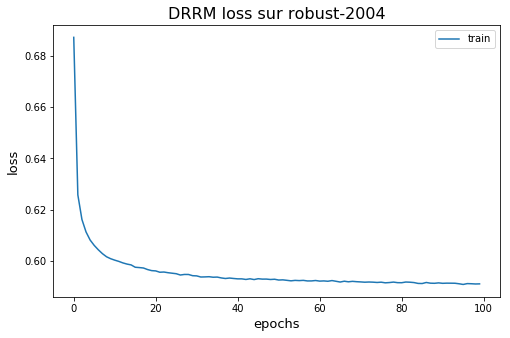

In [13]:
from torch.nn import MarginRankingLoss

drmm = DRMM(30, 4)
print(drmm)

hingeloss = MarginRankingLoss(margin=1.)
optimizer = torch.optim.Adam(drmm.parameters(), lr=0.0005)

make_train_step = drmm_make_train_step(drmm, hingeloss, optimizer)
make_val_step = drmm_make_val_step(drmm, hingeloss, optimizer)

losses = []
val_losses = []
metrics = []
val_metrics = []
nb_epochs = 100

bm25_dict = pickle.load(open("results_bm25_robust.pkl", "rb"))
reranker = Reranker(bm25_dict)

for i in range(nb_epochs):
    #parcourir tous les batches du dataloader
    tiacompris = []
    for pos_batch, neg_batch in train_loader:

        #pos_batch[0]: les interractions positives
        #pos_batch[1]: les query term
        #neg_batch[0]: les interractions négatives correspondantes...
        #neg_batch[1]: les query term correspondantes...
        
        #évaluation empirical loss + backward pass
        tiacompris.append(make_train_step(pos_batch, neg_batch))
    losses.append(np.array(tiacompris).mean())
    
    #évaluation RI
    #reranker.set_model(drmm)
    #lol = reranker.rerank(queries = train)
    #reranker.save_results(lol, "tiacompris")
    #treceval = compute_trec_eval("data/qrels.robust2004.txt", "tiacompris")
    #metrics.append((treceval["map"], treceval["P_20"]))
    
    if i % 10 == 0:
        print("**epoch {}: loss {}**".format(i, losses[-1]))
        #print("**epoch {}: loss {} map {} P_20 {}**".format(i, losses[-1], treceval["map"], treceval["P_20"]))
    
    #on met le modèle en mode "ne calcule pas le gradient"
    #with torch.no_grad():
        #on parcourt
        #for pos_batch_val, neg_batch_val in val_loader:    
            #val_loss = make_val_step(pos_batch_val, neg_batch_val)
        #val_losses.append(val_loss)

plt.figure(figsize=(8,5))
plt.plot(list(range(nb_epochs)), losses, label="train")
#plt.plot(list(range(nb_epochs)), val_losses, label="validation")
plt.title("DRRM loss sur robust-2004", fontsize=16)
plt.ylabel("loss", fontsize=13)
plt.xlabel("epochs", fontsize=13)
plt.legend()
plt.show()

### On peut maintenant tester le modèle avec des métriques de RI:

Pour chacune des requêtes de test, on récupère les 2000 premiers documents retournés par *BM25*. Nous procédons en réordonnant cette liste de documents avec notre modèle *DRMM* appris, et nous calculons des performances sur les 1000 premiers documents de ce re ranking sur un ensemble de métriques de RI (**NDCG@20**, **MAP**, **P@20**), en le comparant avec le ranking original *BM25*.

Pour BM25, l'indexation a été faite comme suit:

- indexation sur le texte du document et non le titre
- texte sans stopwords, ponctuation, balises
- stemming avec Krovetz

<img src="images/learning_to_rank.png">

In [10]:
class Reranker:
    def __init__(self, bm25_dict):
        self.bm25_dict = bm25_dict #le dictionnaire query -> 2000 docs relevants pour bm25
        
    def set_model(self, model):
        self.model = model
    
    def rerank(self, queries=None):
        
        #queries: une liste d'ID de requete pour lesquels on veut réordonner les résultats
        if queries == None:
            queries_to_rerank = list(self.bm25_dict.keys())
        else:
            queries_to_rerank = queries
        
        #pour chaque requete, on va charger réordonner ses résultats avec le modèle
        query_idf = pickle.load(open("saved_data/query_idf.pkl", "rb"))
        reranked_dict = {}
        for id_requete in queries_to_rerank:
            if id_requete != "634":
                with torch.no_grad():
                    #contient une matrice (2000, query_max_len, hist_size)
                    saintjeanlapuenta = np.load("data/bm25_robust/{}_interractions.npy".format(id_requete))
                    a = torch.from_numpy(np.tile(np.array([query_idf[id_requete]]), (saintjeanlapuenta.shape[0],1))).float()

                    model_scores = self.model(torch.from_numpy(saintjeanlapuenta).float(), a).data.numpy()
                    lol = np.argsort(model_scores)[::-1] #tri décroissant

                    # reranked: liste de tuples (document_id, score)
                    reranked_dict[id_requete] = [(self.bm25_dict[id_requete][i][0], model_scores[i]) for i in lol]

        return reranked_dict
    
    def get_results(self, id_requete, rank_list):
        results = []
        for i, (doc_id, score) in enumerate(rank_list[:1000]):
            results.append(" ".join([id_requete, "Q0", doc_id, str(i + 1), str(score), "EARIA"]))
        return results
            
    
    def save_results(self, rank_dict, res_file):
        """
        sauver sur un fichier au format attendu par TREC
        un dictionnaire query_id -> list (doc_id, score)
        """
        results = [f"{id_requete} Q0 EMPTY 1001 -100000 EARIA" for id_requete in rank_dict]
        for id_requete in rank_dict:
            results.extend(self.get_results(id_requete, rank_dict[id_requete]))
        
        with open(res_file, "w") as tiacompris:
            tiacompris.write("\n".join(results))

In [11]:
import subprocess

def compute_trec_eval(qrel_file_path, resp_file_name):
    command = ["trec_eval/trec_eval" , "-c", "-M1001", "-m", "map","-m", "P.20", qrel_file_path, resp_file_name]
    #Le fichier trec_eval est à récuperer ici https://github.com/usnistgov/trec_eval
    # une fois clone, il faut faire un make dans le dossier et autoriser à l'execution (chmod +x)
    completed_process = subprocess.run(command, capture_output=True)
    results = completed_process.stdout.decode("utf-8")
    
    with open("caca", "w") as f:
        f.write(results)
    
    total_score = {}
    for tkt in results.split("\n")[:2]:
        total_score[tkt.split("\t")[0].strip()] = float(tkt.split("\t")[2].strip())
    
    return total_score

In [12]:
def get_results(id_requete, rank_list):
    results = []
    for i, (doc_id, score) in enumerate(rank_list[:1000]):
        results.append(" ".join([id_requete, "Q0", doc_id, str(i + 1), str(score), "EARIA"]))
    return results
            
    
def save_results(rank_dict, res_file, queries):
    """
    sauver sur un fichier au format attendu par TREC
    un dictionnaire query_id -> list (doc_id, score)
    """
    results = [f"{id_requete} Q0 EMPTY 1001 -100000 EARIA" for id_requete in queries]
    for id_requete in queries:
        results.extend(get_results(id_requete, rank_dict[id_requete]))
        
    with open(res_file, "w") as tiacompris:
        tiacompris.write("\n".join(results))

#### MAP et précision avec bm25 seul:

In [14]:
bm25_dict = pickle.load(open("results_bm25_robust.pkl", "rb"))
save_results(bm25_dict, "proutpipi", queries=train)
compute_trec_eval("data/qrels.robust2004.txt", "proutpipi")

{'map': 0.2001, 'P_20': 0.2956}

#### MAP et précision sur le re ranking 

In [15]:
bm25_dict = pickle.load(open("results_bm25_robust.pkl", "rb"))
reranker = Reranker(bm25_dict)
reranker.set_model(drmm)
lol = reranker.rerank(queries = train)
reranker.save_results(lol, "tiacompris")
compute_trec_eval("data/qrels.robust2004.txt", "tiacompris")

/home/ismael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{'map': 0.0156, 'P_20': 0.0161}

#### Perf en test

In [16]:
lol = reranker.rerank(queries = test)
reranker.save_results(lol, "stfe")
compute_trec_eval("data/qrels.robust2004.txt", "stfe")

/home/ismael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{'map': 0.0011, 'P_20': 0.0022}

## Bibliographie


[1] <a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.118.161&rep=rep1&type=pdf">What Works Better for Question Answering: Stemming or
Morphological Query Expansion?</a>

[2] <a href="https://dl.acm.org/citation.cfm?id=160718" >Viewing morphology as an inference process</a>

[3] <a href="https://arxiv.org/pdf/1809.01682.pdf">Deep Relevance Ranking Using Enhanced Document-Query Interactions</a>

[4] <a href="http://delivery.acm.org/10.1145/2810000/2806475/p1411-kenter.pdf?ip=132.227.125.83&id=2806475&acc=ACTIVE%20SERVICE&key=7EBF6E77E86B478F%2EA72B4D473219EA0C%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&__acm__=1562588994_ca050bde6ad37b2c0d433db2e5df63ba">Short Text Similarity with Word Embeddings</a>